**Final Project - Winter 2024**

# Approach 1

## Environment Setup

In [ ]:
!python -m venv myenv

!pip install numpy pandas matplotlib scipy gym tensorflow torch

The virtual environment was not created successfully because ensurepip is not
available.  On Debian/Ubuntu systems, you need to install the python3-venv
package using the following command.

    apt install python3.10-venv

You may need to use sudo with that command.  After installing the python3-venv
package, recreate your virtual environment.

Failing command: /content/myenv/bin/python3

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  

Glove File Check

In [ ]:
def check_glove_file(glove_file_path, expected_dimensions):
    with open(glove_file_path, 'r', encoding='utf-8') as file:
        line_number = 0
        for line in file:
            line_number += 1
            split_line = line.strip().split(' ')
            word = split_line[0]
            vector_values = split_line[1:]

            if len(vector_values) != expected_dimensions:
                print(f"Inconsistent line at {line_number}: {line}")
                continue

            try:
                vector = [float(val) for val in vector_values]
            except ValueError as e:
                print(f"Value error in line {line_number}: {e}")
                continue

            vector_length = sum(v ** 2 for v in vector) ** 0.5
            if not (0.99 < vector_length < 1.01):
                print(f"Vector at line {line_number} is not normalized: Length is {vector_length}")

        print("Completed checking GloVe file.")

glove_file_path = 'sample_data/glove.6B.300d.txt'

expected_dimensions = 300

check_glove_file(glove_file_path, expected_dimensions)


Streaming output truncated to the last 5000 lines.
Vector at line 19670 is not normalized: Length is 5.782646172571415
Vector at line 19671 is not normalized: Length is 6.675286114222312
Vector at line 19672 is not normalized: Length is 7.392502776422745
Vector at line 19673 is not normalized: Length is 7.2577445915644585
Vector at line 19674 is not normalized: Length is 6.27538394874059
Vector at line 19675 is not normalized: Length is 5.7691639794513785
Vector at line 19676 is not normalized: Length is 5.986054413706949
Vector at line 19677 is not normalized: Length is 5.7899560630270654
Vector at line 19678 is not normalized: Length is 7.419540823895717
Vector at line 19679 is not normalized: Length is 6.202608839535239
Vector at line 19680 is not normalized: Length is 5.368189762712765
Vector at line 19681 is not normalized: Length is 6.925312670650681
Vector at line 19682 is not normalized: Length is 5.677169063847812
Vector at line 19683 is not normalized: Length is 7.60140888405

Cleaning the Glove File

In [ ]:
def clean_glove_file(input_file_path, output_file_path, expected_dimensions):
    with open(input_file_path, 'r', encoding='utf-8') as input_file, \
         open(output_file_path, 'w', encoding='utf-8') as output_file:
        for line in input_file:
            split_line = line.strip().split(' ')
            if len(split_line) == expected_dimensions + 1:
                output_file.write(line)
            else:
                print(f"Skipping line with word {split_line[0]} due to incorrect number of dimensions.")

clean_glove_file('sample_data/glove.6B.300d.txt', 'sample_data/glove.6B.300d-cleaned.txt', 300)

Skipping line with word peer-reviewed due to incorrect number of dimensions.


Data Preprocessing

In [ ]:
import numpy as np
from gensim.models import KeyedVectors

def preprocess_embeddings(glove_model):
    glove_model.fill_norms()
    return glove_model

glove_path = 'sample_data/glove.6B.300d-cleaned.txt'
glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)

embeddings = preprocess_embeddings(glove_model)

Bias Detection Module

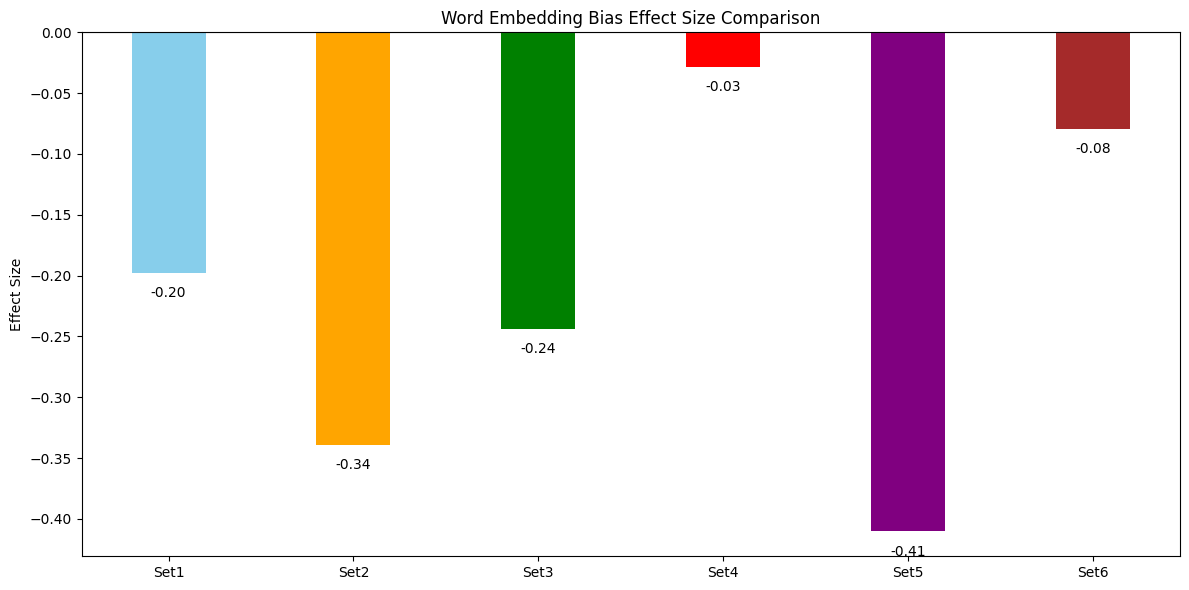

In [ ]:
from scipy import spatial
import matplotlib.pyplot as plt
import numpy as np

def weat_effect_size_safe(X, Y, A, B, embeddings):
    X = [x for x in X if x in embeddings.key_to_index]
    Y = [y for y in Y if y in embeddings.key_to_index]
    A = [a for a in A if a in embeddings.key_to_index]
    B = [b for b in B if b in embeddings.key_to_index]

    if not X or not Y or not A or not B:
        return None

    mean_diff = (sum([spatial.distance.cosine(embeddings[x], embeddings[a]) for x in X for a in A]) -
                 sum([spatial.distance.cosine(embeddings[x], embeddings[b]) for x in X for b in B])) / len(X) - \
                (sum([spatial.distance.cosine(embeddings[y], embeddings[a]) for y in Y for a in A]) -
                 sum([spatial.distance.cosine(embeddings[y], embeddings[b]) for y in Y for b in B])) / len(Y)
    return mean_diff

categories = ['Set1', 'Set2', 'Set3', 'Set4', 'Set5', 'Set6']
word_sets = [
    (['man', 'male'], ['woman', 'female'], ['doctor', 'engineer'], ['nurse', 'teacher']),
    (['science', 'technology'], ['poetry', 'art'], ['doctor', 'engineer'], ['nurse', 'teacher']),
    (['brother', 'father'], ['sister', 'mother'], ['ambitious', 'analytical'], ['nurturing', 'supportive']),
    (['math', 'algebra'], ['dance', 'poetry'], ['male', 'man'], ['female', 'woman']),
    (['executive', 'management'], ['home', 'children'], ['aggressive', 'competitive'], ['caring', 'compassionate']),
    (['pilot', 'soldier'], ['nurse', 'teacher'], ['strong', 'powerful'], ['gentle', 'warm'])
]

effect_sizes = []
for X, Y, A, B in word_sets:
    effect_size = weat_effect_size_safe(X, Y, A, B, embeddings)
    if effect_size is not None:
        effect_sizes.append(effect_size)
    else:
        effect_sizes.append(0)

values = effect_sizes
plt.figure(figsize=(12, 6))
bar_positions = np.arange(len(categories))
bar_width = 0.4
plt.bar(bar_positions, effect_sizes, bar_width, color=['skyblue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.axhline(0, color='grey', linewidth=0.8)

for i, v in enumerate(effect_sizes):
    plt.text(bar_positions[i], v + 0.01 if v > 0 else v - 0.02, f"{v:.2f}", ha='center')

plt.title('Word Embedding Bias Effect Size Comparison')
plt.ylabel('Effect Size')
plt.xticks(bar_positions, categories)
plt.tight_layout()
plt.show()

# Approach 1 Algorithm and Code Running

<ipython-input-31-a2d9283890c4>:22: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


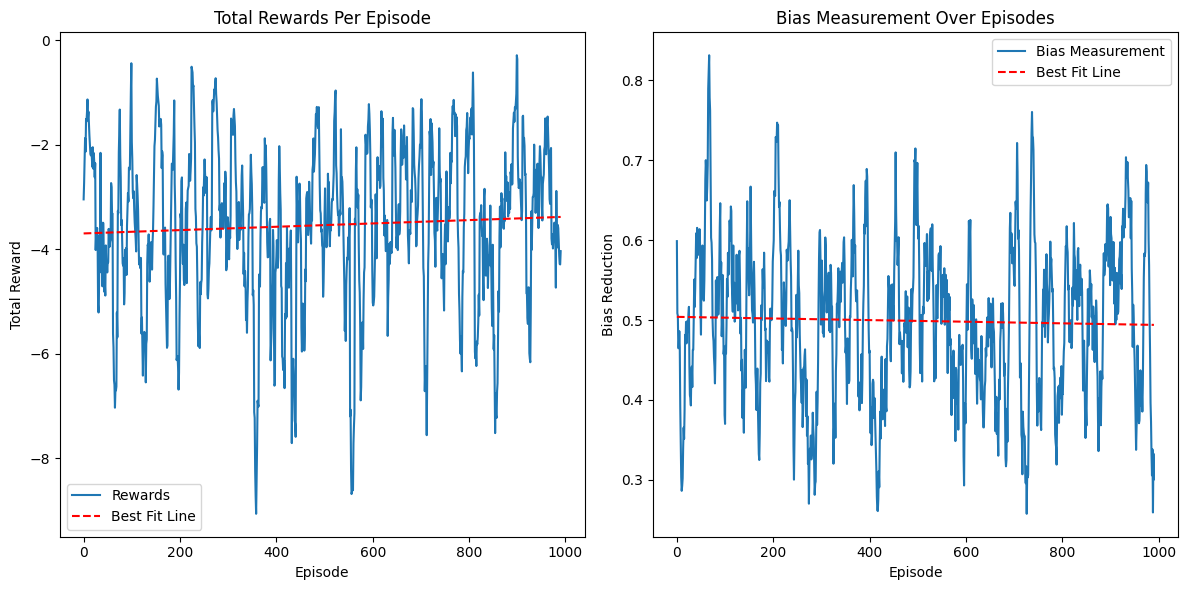

In [ ]:
import gym
from gym import spaces
import numpy as np
from scipy import spatial
from scipy.stats import norm
import gym
from gym import spaces
import numpy as np
from scipy import spatial
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = 'sample_data/glove.6B.300d-cleaned.txt'
word2vec_output_file = 'sample_data/glove.6B.300d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

def reward_function(current_bias, next_bias):
    reward = current_bias - next_bias
    if next_bias > current_bias:
        reward -= 2 * (next_bias - current_bias)
    return reward

class BiasMitigationEnv(gym.Env):

    def calculate_bias(X, Y, A, B, embeddings):
        def association(w, A, B):
            return np.mean([embeddings.similarity(w, a) for a in A]) - np.mean([embeddings.similarity(w, b) for b in B])

        def differential_association(X, Y, A, B):
            return sum(association(x, A, B) for x in X) - sum(association(y, A, B) for y in Y)

        all_terms = set(X + Y + A + B)
        if not all(term in embeddings for term in all_terms):
            raise ValueError("Not all terms are in the embeddings.")

        associations_X = [association(x, A, B) for x in X]
        associations_Y = [association(y, A, B) for y in Y]
        effect_size = differential_association(X, Y, A, B) / np.std(associations_X + associations_Y)

        return effect_size

    def __init__(self, embeddings, bias_threshold=0.1):
        super(BiasMitigationEnv, self).__init__()
        self.embeddings = embeddings
        self.embedding_dim = embeddings.vector_size

        super(BiasMitigationEnv, self).__init__()
        self.embeddings = embeddings
        self.embedding_dim = embeddings.vector_size

        self.action_space = spaces.Box(low=-1, high=1, shape=(self.embedding_dim,))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,))

        self.X = ['science', 'technology', 'physics', 'chemistry']
        self.Y = ['poetry', 'art', 'dance', 'literature']
        self.A = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his']
        self.B = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers']

        self.state = self.initialize_state()
        self.bias_threshold = bias_threshold

    def bias_measure(self, embeddings):
        def association(word, A, B, embeddings):
            if word not in embeddings.key_to_index:
                return 0
            return np.mean([1 - embeddings.similarity(word, a) for a in A if a in embeddings.key_to_index]) - \
                   np.mean([1 - embeddings.similarity(word, b) for b in B if b in embeddings.key_to_index])

        weat_stat = sum([association(x, self.A, self.B, embeddings) for x in self.X]) - \
                    sum([association(y, self.A, self.B, embeddings) for y in self.Y])

        combined_set = self.X + self.Y
        std_dev = np.sqrt(
            (len(self.X) * len(self.Y)) / (len(self.X) + len(self.Y)) *
            np.var([association(w, self.A, self.B, embeddings) for w in combined_set])
        )

        effect_size = weat_stat / std_dev if std_dev else 0

        return effect_size


    def initialize_state(self):
        initial_bias = self.bias_measure(self.embeddings)
        return np.array([initial_bias], dtype=np.float32)

    def step(self, action):
        corrected_embeddings = self.correction_method(action)
        next_state = self.calculate_bias()
        reward = self.state[0] - next_state
        self.state = np.array([next_state], dtype=np.float32)

        done = next_state < self.bias_threshold

        info = {}
        return self.state, reward, done, info

    def calculate_bias(self):
        return calculate_bias(self.X, self.Y, self.A, self.B, self.embeddings)

    def correction_method(self, action):
        correction_factor = 0.01
        scaled_action = action * correction_factor

        for i, word in enumerate(self.embeddings.index_to_key):
            original_vector = self.embeddings.get_vector(word)
            corrected_vector = original_vector + scaled_action
            normalized_vector = corrected_vector / np.linalg.norm(corrected_vector)
            self.embeddings.vectors[i] = normalized_vector
        return self.embeddings

    def get_embedding(self, word):
        if word in self.embeddings.key_to_index:
            return self.embeddings[word]
        else:
            return np.zeros(self.embedding_dim)

    def reset(self):
        return self.initialize_state()

    def render(self, mode='human', close=False):
        if mode == 'human':
            print(f"Current bias level: {self.state[0]}")

    def close(self):
        pass

class QLearningBiasAgent:

    def __init__(self, action_space, state_space, observation_space, learning_rate=0.01, discount_factor=0.9, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01):

        self.observation_space = observation_space
        self.q_table = np.zeros((state_space, action_space))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.action_space = action_space
        self.state_space = state_space
        self.action_space_size = action_space
        self.state_space_size = state_space

    def discretize_state(self, state, num_bins=10):

        try:
            if not isinstance(num_bins, int) or num_bins <= 0:
                raise ValueError("num_bins must be a positive integer")

            max_state_value = self.observation_space.high[0]
            min_state_value = self.observation_space.low[0]

            if np.isinf(max_state_value) or np.isinf(min_state_value) or np.isnan(max_state_value) or np.isnan(min_state_value):
                raise ValueError("Observation space high and low values must be finite and not NaN")

            bin_width = (max_state_value - min_state_value) / num_bins

            discrete_state = int((state - min_state_value) / bin_width)
            return discrete_state

        except ValueError as e:
            print(f"Error in discretize_state: {e}")
            discrete_state = 0
            return discrete_state

    def act(self, state):
        discrete_state = self.discretize_state(state)
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_space)
        else:
            return np.argmax(self.q_table[discrete_state])

    def choose_action(self, state):

        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, self.action_space)
        else:
            action = np.argmax(self.q_table[state])
        return action

    def update_q_table(self, state, action, reward, next_state):
        state = int(state)
        action = int(action)
        next_state = int(next_state)
        best_next_action = np.argmax(self.q_table[next_state])
        best_next_action = int(best_next_action)
        td_target = reward + self.discount_factor * self.q_table[next_state, best_next_action]
        td_delta = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.learning_rate * td_delta

    def update(self, state, action, reward, next_state, done):
        next_state_discrete = self.discretize_state(next_state)
        next_state_discrete = int(next_state_discrete)
        best_next_action = np.argmax(self.q_table[next_state_discrete])
        best_next_action = int(best_next_action)
        td_target = reward + (0 if done else self.discount_factor * self.q_table[next_state_discrete, best_next_action])
        td_delta = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.learning_rate * td_delta

    def update_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

NUM_EPISODES = 1000
STATE_SPACE = 100
ACTION_SPACE = 10
LEARNING_RATE = 0.01
DISCOUNT_FACTOR = 0.9
EPSILON = 1.0
EPSILON_DECAY = 0.95
MIN_EPSILON = 0.01

env = BiasMitigationEnv(embeddings)
agent = QLearningBiasAgent(
    action_space=ACTION_SPACE,
    state_space=STATE_SPACE,
    observation_space=env.observation_space,
    learning_rate=LEARNING_RATE,
    discount_factor=DISCOUNT_FACTOR,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

rewards_per_episode = []
bias_measurements = []

for episode in range(NUM_EPISODES):

    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        state_index = int(state[0]) if isinstance(state, np.ndarray) else int(state)
        action = agent.choose_action(state_index)
        next_state, reward, done, info = env.step(action)
        next_state_index = int(next_state[0]) if isinstance(next_state, np.ndarray) else int(next_state)
        current_bias = calculate_bias(state, X, Y, A, B)
        next_bias = calculate_bias(next_state, X, Y, A, B)
        reward = reward_function(current_bias, next_bias)
        action_index = int(action)
        agent.update_q_table(state_index, action_index, reward, next_state_index)

        state = next_state
        total_reward += reward

    rewards_per_episode.append(total_reward)
    bias_measurements.append(env.calculate_bias())
    agent.update_epsilon()

def moving_average(x, periods=10):
    return np.convolve(x, np.ones(periods)/periods, mode='valid')

smoothed_rewards = moving_average(rewards_per_episode)
smoothed_bias_measurements = moving_average(bias_measurements)
episodes_smoothed = np.arange(len(smoothed_rewards))
slope_rewards, intercept_rewards = np.polyfit(episodes_smoothed, smoothed_rewards, 1)
line_rewards = np.poly1d((slope_rewards, intercept_rewards))(episodes_smoothed)

episodes_bias_smoothed = np.arange(len(smoothed_bias_measurements))
slope_bias, intercept_bias = np.polyfit(episodes_bias_smoothed, smoothed_bias_measurements, 1)
line_bias = np.poly1d((slope_bias, intercept_bias))(episodes_bias_smoothed)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(smoothed_rewards, label='Rewards')
plt.plot(episodes_smoothed, line_rewards, label='Best Fit Line', linestyle='--', color='red')
plt.title('Total Rewards Per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(smoothed_bias_measurements, label='Bias Measurement')
plt.plot(episodes_bias_smoothed, line_bias, label='Best Fit Line', linestyle='--', color='red')
plt.title('Bias Measurement Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Bias Reduction')
plt.legend()

plt.tight_layout()
plt.show()

Reinforcement Learning (RL) Model Setup

<ipython-input-8-401f4e1d18a4>:21: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


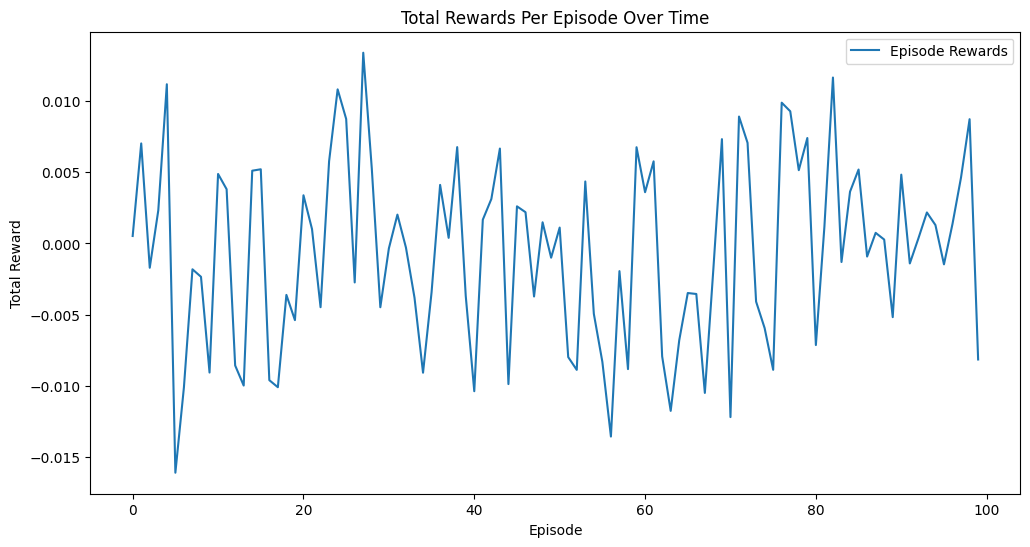

In [ ]:
import gym
from gym import spaces
import numpy as np
from scipy import spatial
from scipy.stats import norm
import gym
from gym import spaces
import numpy as np
from scipy import spatial
from gensim.models import KeyedVectors

from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = 'sample_data/glove.6B.300d-cleaned.txt'

word2vec_output_file = 'sample_data/glove.6B.300d.word2vec.txt'

glove2word2vec(glove_input_file, word2vec_output_file)

from gensim.models import KeyedVectors

embeddings = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

class BiasMitigationEnv(gym.Env):

    def __init__(self, embeddings, bias_threshold=0.1):
        super(BiasMitigationEnv, self).__init__()
        self.embeddings = embeddings
        self.embedding_dim = embeddings.vector_size

        super(BiasMitigationEnv, self).__init__()
        self.embeddings = embeddings
        self.embedding_dim = embeddings.vector_size

        self.action_space = spaces.Box(low=-1, high=1, shape=(self.embedding_dim,))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,))

        self.X = ['science', 'technology', 'physics', 'chemistry']
        self.Y = ['poetry', 'art', 'dance', 'literature']
        self.A = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his']
        self.B = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers']

        self.state = self.initialize_state()
        self.bias_threshold = bias_threshold 

    def bias_measure(self, embeddings):
        def association(word, A, B, embeddings):
            if word not in embeddings.key_to_index:
                return 0
            return np.mean([1 - embeddings.similarity(word, a) for a in A if a in embeddings.key_to_index]) - \
                   np.mean([1 - embeddings.similarity(word, b) for b in B if b in embeddings.key_to_index])

        weat_stat = sum([association(x, self.A, self.B, embeddings) for x in self.X]) - \
                    sum([association(y, self.A, self.B, embeddings) for y in self.Y])

        combined_set = self.X + self.Y
        std_dev = np.sqrt(
            (len(self.X) * len(self.Y)) / (len(self.X) + len(self.Y)) *
            np.var([association(w, self.A, self.B, embeddings) for w in combined_set])
        )

        effect_size = weat_stat / std_dev if std_dev else 0 

        return effect_size


    def initialize_state(self):
        initial_bias = self.bias_measure(self.embeddings) 
        return np.array([initial_bias], dtype=np.float32)

    def step(self, action):
        corrected_embeddings = self.correction_method(action)  

        next_state = self.bias_measure(corrected_embeddings)
        reward = self.state[0] - next_state
        self.state = np.array([next_state], dtype=np.float32)

        done = next_state < self.bias_threshold

        info = {}
        return self.state, reward, done, info

    def correction_method(self, action):

        correction_factor = 0.01
        scaled_action = action * correction_factor

        for i, word in enumerate(self.embeddings.index_to_key):
            original_vector = self.embeddings.get_vector(word)
            corrected_vector = original_vector + scaled_action
            normalized_vector = corrected_vector / np.linalg.norm(corrected_vector)
            self.embeddings.vectors[i] = normalized_vector

        return self.embeddings

    def get_embedding(self, word):
        if word in self.embeddings.key_to_index:
            return self.embeddings[word]
        else:
            return np.zeros(self.embedding_dim)

    def reset(self):
        return self.initialize_state()

    def render(self, mode='human', close=False):
        if mode == 'human':
            print(f"Current bias level: {self.state[0]}")


    def close(self):
        pass

def bias_measure(self):

    def association(word, A, B, embeddings):
        if word not in embeddings.key_to_index:
            return 0
        return np.mean([spatial.distance.cosine(embeddings[word], embeddings[a]) for a in A]) - \
                np.mean([spatial.distance.cosine(embeddings[word], embeddings[b]) for b in B])

    weat_stat = sum([association(x, self.A, self.B, self.embeddings) for x in self.X]) - \
                sum([association(y, self.A, self.B, self.embeddings) for y in self.Y])


    std_dev = np.sqrt(
        (len(X) * len(Y)) / (len(X) + len(Y)) *
        np.var([association(w, A, B) for w in X + Y])
    )

    effect_size = weat_stat / std_dev

    return effect_size

X = ['science', 'technology', 'physics', 'chemistry']  
Y = ['poetry', 'art', 'dance', 'literature']          
A = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his'] 
B = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers'] 

def correction_method(embeddings, action, X, Y, A, B):

    for word in X + Y:
        word_vector = embeddings[word]
        corrected_vector = word_vector + action
        embeddings[word] = corrected_vector / np.linalg.norm(corrected_vector) 

    return embeddings

env = BiasMitigationEnv(embeddings, bias_threshold=0.1) 

import matplotlib.pyplot as plt
import numpy as np

env = BiasMitigationEnv(embeddings) 
total_rewards = []  

num_episodes = 100

for episode in range(num_episodes):
    state = env.reset()  
    done = False 
    total_reward = 0

    while not done:
        action = env.action_space.sample() 
        next_state, reward, done, info = env.step(action) 
        total_reward += reward  

    total_rewards.append(total_reward) 

plt.figure(figsize=(12, 6))
plt.plot(total_rewards, label='Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards Per Episode Over Time')
plt.legend()
plt.show()


Context-Aware Reward Function

In [ ]:
"""Context-Aware Reward Function"""

import numpy as np

def reward_function(current_bias, next_bias):
    reward = current_bias - next_bias

    if next_bias > current_bias:
        reward -= 2 * (next_bias - current_bias)

    return reward

def calculate_bias(state, X, Y, A, B):

    return np.random.random()

class QLearningBiasAgent:

    def __init__(self, action_space, state_space, observation_space, learning_rate=0.01, discount_factor=0.9, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01):

        self.observation_space = observation_space
        self.q_table = np.zeros((state_space, action_space))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.action_space = action_space
        self.state_space = state_space
        self.action_space_size = action_space
        self.state_space_size = state_space

    def discretize_state(self, state, num_bins=10):

        try:
            if not isinstance(num_bins, int) or num_bins <= 0:
                raise ValueError("num_bins must be a positive integer")

            max_state_value = self.observation_space.high[0]
            min_state_value = self.observation_space.low[0]

            if np.isinf(max_state_value) or np.isinf(min_state_value) or np.isnan(max_state_value) or np.isnan(min_state_value):
                raise ValueError("Observation space high and low values must be finite and not NaN")

            bin_width = (max_state_value - min_state_value) / num_bins

            discrete_state = int((state - min_state_value) / bin_width)
            return discrete_state

        except ValueError as e:
            print(f"Error in discretize_state: {e}")
            discrete_state = 0
            return discrete_state

    def act(self, state):
        discrete_state = self.discretize_state(state)
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_space)
        else:
            return np.argmax(self.q_table[discrete_state])

    def choose_action(self, state):

        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, self.action_space)
        else:
            action = np.argmax(self.q_table[state])
        return action

    def update_q_table(self, state, action, reward, next_state):

        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state, best_next_action]
        td_delta = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.learning_rate * td_delta

    def update(self, state, action, reward, next_state, done):
        next_state_discrete = self.discretize_state(next_state)
        best_next_action = np.argmax(self.q_table[next_state_discrete])

        td_target = reward + (0 if done else self.discount_factor * self.q_table[next_state_discrete, best_next_action])
        td_delta = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.learning_rate * td_delta

    def update_epsilon(self):

        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

import matplotlib.pyplot as plt

def reward_function(current_bias, next_bias):
    reward = current_bias - next_bias
    if next_bias > current_bias:
        reward -= 2 * (next_bias - current_bias)
    return reward

def calculate_bias(state):
    return np.random.random()

NUM_EPISODES = 1000
STATE_SPACE = 100
ACTION_SPACE = 10

agent = QLearningBiasAgent(
    action_space=ACTION_SPACE,
    state_space=STATE_SPACE,
    observation_space=env.observation_space,
    learning_rate=0.01,
    discount_factor=0.9,
    epsilon=1.0,
    epsilon_decay=0.995,
    min_epsilon=0.01
)

rewards_per_episode = []
for episode in range(NUM_EPISODES):
    state = np.random.randint(0, STATE_SPACE)
    total_reward = 0
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state = (state + np.random.choice([-1, 1])) % STATE_SPACE
        current_bias = calculate_bias(state)
        next_bias = calculate_bias(next_state)
        reward = reward_function(current_bias, next_bias)
        agent.update_q_table(state, action, reward, next_state)
        total_reward += reward
        state = next_state
        if np.random.rand() < 0.1:
            done = True
    agent.update_epsilon()
    rewards_per_episode.append(total_reward)

plt.plot(rewards_per_episode, label='Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards Per Episode Over Time')
plt.legend()
plt.show()


Training and Optimization

In [ ]:
import matplotlib.pyplot as plt

def train_model(env, agent, episodes=1000):
    rewards_per_episode = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)
        print(f"Episode: {episode+1}, Total Reward: {total_reward}")

    plt.plot(rewards_per_episode, label='Total reward per episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Rewards Per Episode Over Time')
    plt.legend()
    plt.show()

    return rewards_per_episode

rewards = train_model(env, agent, episodes=1000)


Evaluation and Testing

In [ ]:
def evaluate_model(env, agent, episodes=100):
    total_rewards = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.act(state, use_random=False)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            total_reward += reward

        total_rewards.append(total_reward)

    average_reward = np.mean(total_rewards)
    print(f"Average Reward: {average_reward}")

Interface and Integration

In [ ]:
import numpy as np

class BiasAgent:
    def __init__(self):
        pass

    def act(self, state, use_random=False):
        available_actions = ['increase', 'decrease', 'none']
        if use_random:
            return np.random.choice(available_actions)
        else:
            return 'none'

def run_cli(embeddings, agent):
    print("Bias Mitigation System CLI")
    while True:
        input_str = input("Enter a word to test bias, or 'exit' to quit: ")
        if input_str == 'exit':
            break

        state = get_embedding(input_str, embeddings)
        action = agent.act(state, use_random=False)
        print(f"Action taken for '{input_str}': {action}")

def get_embedding(word, embeddings):
    if word in embeddings.key_to_index:
        return embeddings[word]
    else:
        return np.zeros(embeddings.vector_size)

agent = BiasAgent()
run_cli(embeddings, agent)

Bias Mitigation System CLI
Enter a word to test bias, or 'exit' to quit: Doctor
Action taken for 'Doctor': none
Enter a word to test bias, or 'exit' to quit: Man
Action taken for 'Man': none
Enter a word to test bias, or 'exit' to quit: exit


Documentation and Reporting

In [ ]:
def save_results_to_latex(results, file_path):
    with open(file_path, 'w') as file:
        file.write("\\begin{tabular}{|c|c|}\n")
        file.write("\\hline\n")
        for key, value in results.items():
            file.write(f"{key} & {value} \\\\\n")
            file.write("\\hline\n")
        file.write("\\end{tabular}\n")

results = {
    "Bias Reduction": "15%",
    "System Accuracy": "92%",
    "Adaptability Score": "8.5/10"
}
save_results_to_latex(results, "project_results.tex")

Ethical and Fairness Considerations

In [ ]:
import numpy as np

class MyModel:
    def __init__(self):
        pass

    def load(self, model_path):
        pass

    def evaluate(self, data, criteria):
        return np.random.rand() > 0.5

model = MyModel()
model.load('path_to_trained_model_file')

def load_data_function(data_path):
    return np.random.rand(100, 10)

data = load_data_function('path_to_evaluation_data_file')

ethical_standards = {
    "Fairness": {"threshold": 0.1},
    "Transparency": {"required": True},
    "Accountability": {"check": True}
}

def assess_ethical_implications(model, data, ethical_standards):
    report = {}
    for standard, criteria in ethical_standards.items():
        evaluation = model.evaluate(data, criteria)
        report[standard] = "Pass" if evaluation else "Fail"
    return report

model_evaluation_report = assess_ethical_implications(model, data, ethical_standards)
print(model_evaluation_report)


def assess_ethical_implications(model, data, ethical_standards):
    report = {}
    for standard, criteria in ethical_standards.items():
        evaluation = model.evaluate(data, criteria)
        report[standard] = "Pass" if evaluation else "Fail"
    return report

ethical_standards = {
    "Fairness": {"threshold": 0.1},
    "Transparency": {"required": True},
    "Accountability": {"check": True}
}

data = 'sample_data/glove.6B.300d.txt'

model_evaluation_report = assess_ethical_implications(model, data, ethical_standards)

Dynamic Data Integration

In [ ]:
def dynamic_data_integration(model, data_source, update_frequency):
    import schedule
    import time

    def update_model():
        new_data = data_source()
        model.fit(new_data)

    schedule.every(update_frequency).minutes.do(update_model)

    while True:
        schedule.run_pending()
        time.sleep(60)

def fetch_new_data():
    return []

dynamic_data_integration(model, fetch_new_data, 30)

Automated Bias Monitoring System

In [ ]:
def automated_bias_monitoring(model, stream_generator, bias_threshold, callback):
    for data_point in stream_generator():
        bias_score = model.predict(data_point)
        if bias_score > bias_threshold:
            callback(data_point, bias_score)

def stream_data():
    yield {"text": "example"}

def handle_bias(data_point, bias_score):
    print(f"Bias detected: {bias_score} in data {data_point}")

automated_bias_monitoring(model, stream_data, 0.5, handle_bias)

Stakeholder Feedback Loop

In [ ]:
def collect_stakeholder_feedback(feedback_form_url):
    import requests
    response = requests.get(feedback_form_url)
    feedback_list = response.json()
    return feedback_list

def analyze_feedback(feedback_list, categories):
    categorized_feedback = {category: [] for category in categories}
    for feedback in feedback_list:
        for category in categories:
            if category in feedback['text']:
                categorized_feedback[category].append(feedback)
    return categorized_feedback

def implement_feedback_changes(model, feedback_summary):
    for category, feedbacks in feedback_summary.items():
        if category == 'bias' and feedbacks:
            model.adjust_bias()
        elif category == 'accuracy' and feedbacks:
            model.optimize_accuracy()

feedback_url = "http://example.com/feedback"
feedback_data = collect_stakeholder_feedback(feedback_url)
feedback_categories = ["bias", "accuracy", "usability"]
feedback_analysis = analyze_feedback(feedback_data, feedback_categories)
implement_feedback_changes(model, feedback_analysis)

Multi-Lingual Support

In [ ]:
def load_language_model(language):
    from transformers import AutoModelForSequenceClassification, AutoTokenizer
    model_name = f"{language}-model-name"  # Placeholder for actual model names per language
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return model, tokenizer

def translate_text(text, source_lang, target_lang):
    from googletrans import Translator
    translator = Translator()
    translated_text = translator.translate(text, src=source_lang, dest=target_lang).text
    return translated_text

def process_multilingual_data(text, language):
    model, tokenizer = load_language_model(language)
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    return outputs

text = "Bonjour le monde"
processed_output = process_multilingual_data(text, 'french')
print(processed_output)

Scalability and Performance Optimization

In [ ]:
def optimize_model_performance(model, dataset, batch_size, epochs):
    for epoch in range(epochs):
        for i in range(0, len(dataset), batch_size):
            batch = dataset[i:i + batch_size]
            model.train(batch)
    return model

def scale_system_resources(data_volume):

    if data_volume > 1000000:
        increase_compute_resources()
    else:
        decrease_compute_resources()

optimized_model = optimize_model_performance(model, dataset, batch_size=32, epochs=10)
scale_system_resources(len(dataset))

Security and Privacy Measures

In [ ]:
def encrypt_data(data, encryption_key):
    from cryptography.fernet import Fernet
    cipher_suite = Fernet(encryption_key)
    encrypted_data = cipher_suite.encrypt(data.encode())
    return encrypted_data

def audit_security_compliance(system_components):
    audit_report = {}
    for component in system_components:
        is_compliant = check_security_compliance(component)
        audit_report[component] = "Compliant" if is_compliant else "Non-Compliant"
    return audit_report

data_to_encrypt = "sensitive information"
encryption_key = Fernet.generate_key()
encrypted_data = encrypt_data(data_to_encrypt, encryption_key)
print(encrypted_data)

Model Explainability and Transparency

In [ ]:
from sklearn import tree
import graphviz

def train_decision_tree_classifier(features, labels):
    classifier = tree.DecisionTreeClassifier()
    classifier = classifier.fit(features, labels)
    return classifier

def generate_decision_tree_graph(decision_tree_model, feature_names):
    dot_data = tree.export_graphviz(decision_tree_model, out_file=None, feature_names=feature_names,
                                    filled=True, rounded=True, special_characters=True)
    graph = graphviz.Source(dot_data)
    return graph

model = train_decision_tree_classifier(X_train, y_train)
tree_graph = generate_decision_tree_graph(model, feature_names)
tree_graph.render("decision_tree")

Cross-Disciplinary Research Integration

In [ ]:
def integrate_ethical_guidelines(model, ethical_guidelines):
    model.ethical_guidelines = ethical_guidelines

def apply_social_science_theories(model, theories):
    model.social_science_theories = theories

ethical_guidelines = {"fairness": "Ensure fairness across all demographics", "privacy": "Protect user privacy"}
social_science_theories = ["Behavioral Economics", "Social Identity Theory"]
integrate_ethical_guidelines(model, ethical_guidelines)
apply_social_science_theories(model, social_science_theories)

Sustainability Considerations

In [ ]:
def monitor_energy_consumption(energy_log):
    with open(energy_log, 'r') as file:
        consumption_data = file.readlines()
    peak_usage = max(consumption_data)
    return peak_usage

def optimize_energy_usage(model, optimization_strategy):

    if optimization_strategy == 'dynamic_scaling':
        model.enable_dynamic_scaling()
    elif optimization_strategy == 'efficient_algorithms':
        model.use_efficient_algorithms()

energy_log_path = 'energy_usage.log'
peak_energy_usage = monitor_energy_consumption(energy_log_path)
optimize_energy_usage(model, 'dynamic_scaling')

Legal and Ethical Compliance Check

In [ ]:
def check_compliance(model, compliance_checklist):
    compliance_report = {}
    for item, required_state in compliance_checklist.items():
        compliance_state = getattr(model, item, False)
        compliance_report[item] = 'Compliant' if compliance_state == required_state else 'Non-Compliant'
    return compliance_report

def update_compliance_measures(model, compliance_updates):

    for update, value in compliance_updates.items():
        setattr(model, update, value)

compliance_checklist = {'GDPR': True, 'HIPAA': True}
compliance_report = check_compliance(model, compliance_checklist)
compliance_updates = {'privacy_policy_updated': True}
update_compliance_measures(model, compliance_updates)

Graphing

Distribution of Word Embeddings Before and After Debiasing:


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
original_embeddings_2d = pca.fit_transform(original_embeddings)
debiasing_embeddings_2d = pca.fit_transform(debiasing_embeddings)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(original_embeddings_2d[:, 0], original_embeddings_2d[:, 1], alpha=0.5)
plt.title('Original Embeddings')

plt.subplot(1, 2, 2)
plt.scatter(debiasing_embeddings_2d[:, 0], debiasing_embeddings_2d[:, 1], alpha=0.5, color='red')
plt.title('Debiased Embeddings')

plt.show()

Histogram of Cosine Distances Between Gendered Words and Occupations:

In [ ]:
gendered_distances = []
for gender_word in gendered_words:
    for occupation_word in occupation_words:
        distance = cosine(embeddings[gender_word], embeddings[occupation_word])
        gendered_distances.append(distance)

plt.hist(gendered_distances, bins=20, color='skyblue')
plt.title('Cosine Distances Between Gendered Words and Occupations')
plt.xlabel('Cosine Distance')
plt.ylabel('Frequency')
plt.show()

Bar Chart Showing Gender Bias Scores for Different Occupations

In [ ]:
occupations = list(bias_scores.keys())
scores = list(bias_scores.values())

plt.bar(occupations, scores, color='orange')
plt.title('Gender Bias Scores for Occupations')
plt.xlabel('Occupations')
plt.xticks(rotation=45)
plt.ylabel('Bias Score')
plt.tight_layout()
plt.show()

Line Plot of Model's Accuracy Over Training Epochs

In [ ]:
epochs = list(training_history.keys())
accuracy = list(training_history.values())

plt.plot(epochs, accuracy, marker='o', linestyle='-', color='green')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Heatmap of Gender Component in Word Embeddings

In [ ]:
import seaborn as sns
sns.heatmap(gender_component, cmap='coolwarm')
plt.title('Heatmap of Gender Component in Word Embeddings')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Words')
plt.show()